## Network Analysis
We defined correlation between businesses based on user-rated 'stars'. The star ranking takes values ranging between 1 - 5. When the star-ranking is positively correlated between two businesses, they are connected with a red edge in the business network. When the star-ranking is negatively correlated between two businesses, they are connected with a blue edge. We used Spearman's ranked correlation analysis.

In [1]:
from load_yelp_data import load_yelp_dataframe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
import networkx as nx
import random

In [2]:
businesses = load_yelp_dataframe('businesses').drop('Unnamed: 0', 1)
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
users = load_yelp_dataframe('users').drop('Unnamed: 0', 1)

In [3]:
#Top 5 cities included in the businesses dataset
businesses['city'].value_counts()[:5]

Las Vegas     19328
Phoenix       11852
Charlotte      5695
Scottsdale     5638
Montréal       4371
Name: city, dtype: int64

In [3]:
#Choose Phoenix only
businesses_phoenix = businesses[businesses['city'] == 'Phoenix']
#Rename duplicated column names
businesses_phoenix = businesses_phoenix.rename(columns = {'stars': 'stars_business'})
#Merge with the reviews dataset
reviews_phoenix = reviews.merge(businesses_phoenix, how='inner', on='business_id') 

#When users reviewed a business more than once, take the most updated review result
reviews_phoenix = reviews_phoenix.sort_values(by=['year', 'month', 'day'], ascending=True, axis=0)
reviews_phoenix_nodup = reviews_phoenix.drop_duplicates(subset=('user_id', 'business_id'), keep='last')

#Transform the dataset to have business_id in columns and user_id in row
reviews_phoenix_nodup = reviews_phoenix_nodup[['user_id', 'business_id', 'stars']]
#reviews_phoenix_nodup_t = reviews_phoenix_nodup.pivot(index='user_id', columns='business_id', values='stars')
###Due to memory error, I cannot use whole dataset (N=353620)###

In [4]:
#Temporally create random subset
permutated = reviews_phoenix_nodup.reindex(np.random.permutation(reviews_phoenix_nodup.index))
subset = reviews_phoenix_nodup.iloc[:10000, :]
subset_t = subset.pivot(index='user_id', columns='business_id', values='stars')

#Create correlation matrix
corr_matrix = subset_t.corr(method='spearman')

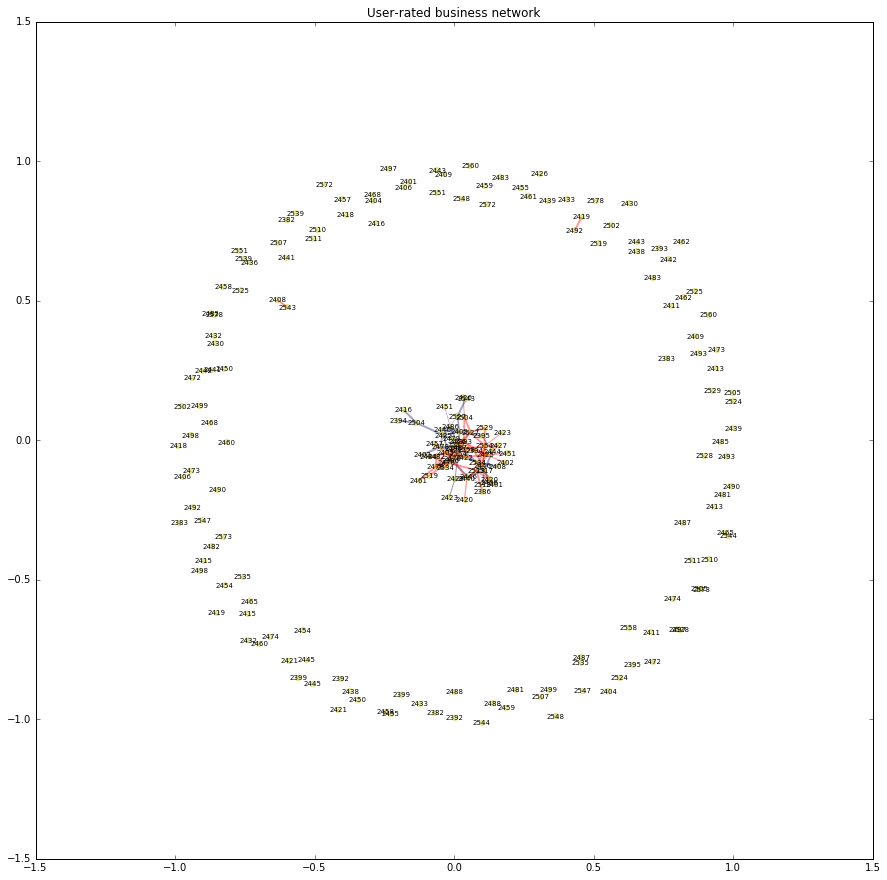

In [43]:
#So many businesses and, we only choses some businesses for now
corr_subx = corr_matrix.iloc[:100, :100]
corr_sub = corr_subx.reset_index().values

#Construct network
node0=[]
node1=[]
weight0=[]
weight1=[]
columns=corr_subx.columns.values
for i, line in enumerate(corr_sub):
    tokens=corr_sub[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i*(-2) for i in weight0]
weight1x=[i*2 for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('User-rated business network')
nx.draw_networkx(G0, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

This preliminary analysis only included 100 businesses (to clearly see the network structure) located in Phoenix. The node in the network figure indicates a business ID, and an edge represents a connection between businesses. The correlation coefficients were calcuated using Spearman's ranked correlation analysis. The red color indicates positive correlation, and the blue color is negative correlation between businesses. The above figure shows that this is an sparse network, and most of the businesses were not rated by users.

In the next step, we will further focus on a specific type of businesses (e.g., restaurant), and refine the selection criteria for cities.